# Prepare the Notebook for Colab

In [0]:
!pip install control
!git clone https://magiccvs.byu.edu/gitlab/control_book/control_book_public_solutions.git
!cd control_book_public_solutions/;  #git checkout Fall19_edits; 

     |████████████████████████████████| 256kB 2.8MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=beb6b894c055b81906eab308de967f8988a9ca4a7eb7f3de509cf418920ba2b0
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control
Cloning into 'control_book_public_solutions'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 2444 (delta 2), reused 0 (delta 0), pack-reused 2432
Receiving objects: 100% (2444/2444), 42.78 MiB | 21.50 MiB/s, done.
Resolving deltas: 100% (1257/1257), done.
error: pathspec 'Fall19_edits' did not match any file(s) known to git.


In [0]:
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8) #set the figure size
from IPython.display import Latex
from IPython.display import Image

In [0]:
# How to bring in figures from the git repository
basename = 'control_book_public_solutions/_images/' # use for Google Colab Notebooks
#basename = './' # Use for self-hosted jupyter notebooks
Img1 = Image(filename=basename+'figures_5/ls_slc.png',width=700)

# Part 5: Loopshaping Control Design
## Chapter 18: Compensator Design

### Lecture Notes

This notebook covers the material in Chapter 18 of the [text](http://controlbook.byu.edu/doku.php) in brief form, allowing you to make changes and manipulate the examples.  The goal is for this resource to help you bridge the gap between theory and the practical.

## 18.1 Theory
We will first walk through the six building blocks for a compensator, one method for a discrete implementation and then we will augement a PID control design in the frequency domain.  The six building blocks are: 
 - Proportional Gain
 - Integral (PI) Control
 - Low Pass Filter
 - Phase Lag Filter
 - Phase Lead Filter
 - Pre-filter

Recall that we can design each of these components separately and then simply add them together because we are in the Lineart Time-invariant domain: 


$20\log_{10}|PC| = 20\log_{10}|P| + \sum_{i=1}^q 20\log_{10}|C_i| $

$\angle PC = \angle P + \sum_{i=1}^q \angle C_i.$


### 18.1.1 Proportional Control
$C_P(s) = k_P$

Note that a proportional controller can **only be used to change the magnitude plot**.  It is usually added to affect the crossover frequency, after the other components have been added. 

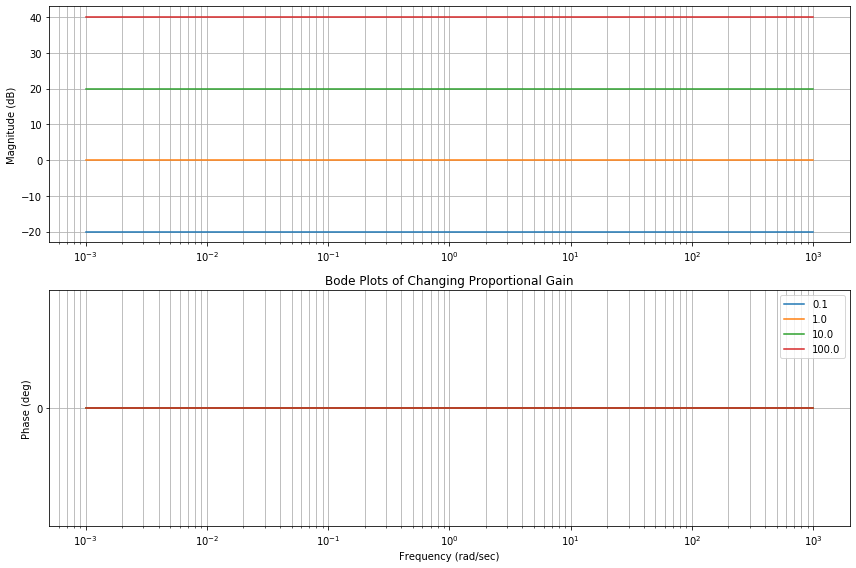

In [0]:
omega = (0.001,1000)
kp = np.array([0.1,1.,10.,100.])

for i in range(0,kp.size):
    Cp = tf([kp[i]],[1.])
    plt.title('Bode Plots of Changing Proportional Gain')
    mag, phase, w = bode(Cp,omega_limits=omega, Hz=False, label=str(kp[i])) 
plt.legend(loc=0)
plt.tight_layout()


### 18.1.2 Integral Control
$C_I(s) = \frac{s + k_I}{s}$ is the approach for using PI control, with $k_p = 1$. 

Integral control is used to change the system type, **which changes the slope of the loop gain by -20 dB/decade** at low frequencies, up to $\omega < k_I$.  Integral control also decreases the phase at low frequencies, which has impacts on stability - so usually, you want $k_I < < \omega_{co}$.  Note in the figure below that $k_I$s is the location in frequency for the knee in magnitude and for the midpoint of the phase change.

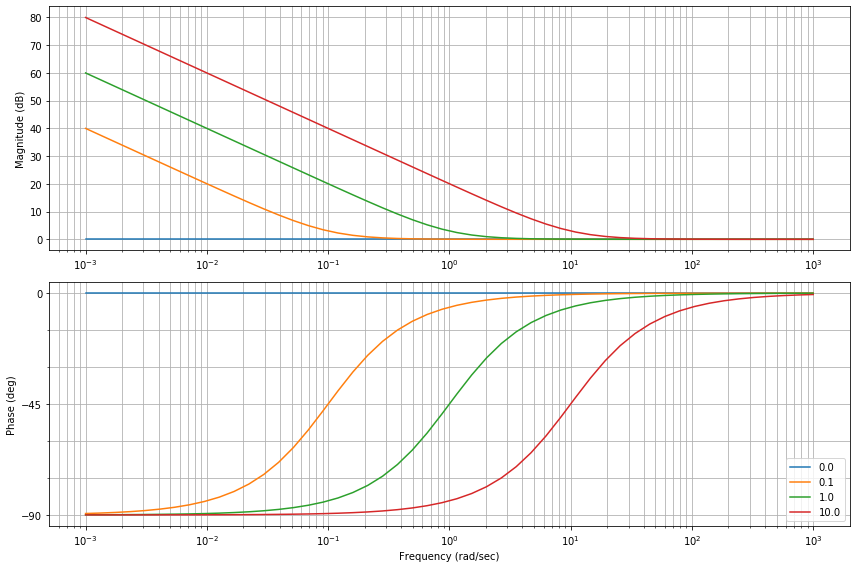

In [0]:
plt.figure()
ki = np.array([0.0,0.1,1.,10.])
for i in range(0,ki.size):
    Ci = tf([1., ki[i]],[1., 0.])
    mag, phase, w = bode(Ci, omega_limits=omega, Hz=False, label=str(ki[i]))     
plt.legend(loc=0)
plt.tight_layout()


### 18.1.3 Low Pass Filter
$C_{lpf} = \frac{p}{s + p}$

The low pass filter is going to attentuate the loopgain (and increase the phase) when $\omega > p$ to **attenuate high frequency noise**.  Note that  is the location in frequency for the knee in magnitude and the mid point for the phase changes in the figure below. 

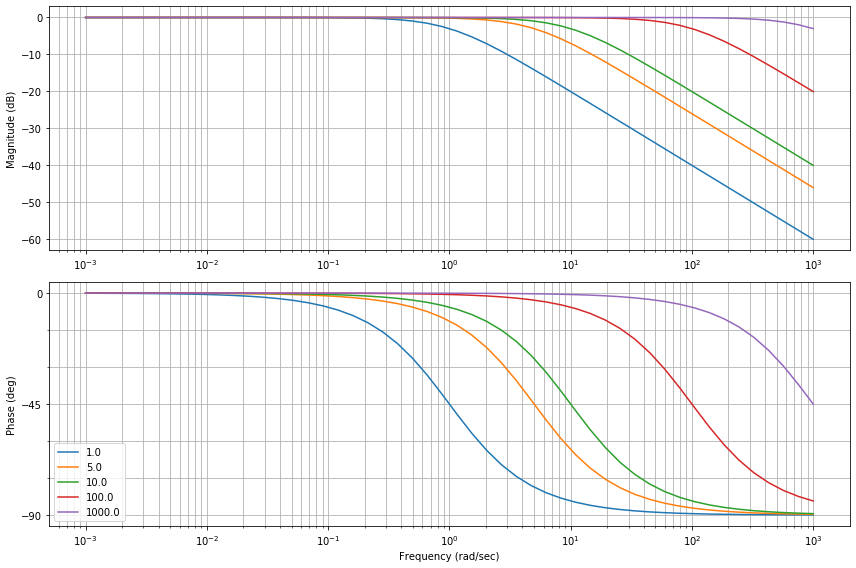

In [0]:
p = np.array([1.,5.,10.,100.,1000.])

for i in range(0,p.size):
    Clpf = tf([p[i]],[1., p[i]]) 
    mag, phase, w = bode(Clpf, omega_limits=omega, Hz=False, label=str(p[i]))
                        
plt.legend()
plt.tight_layout()

### 18.1.4 Phase Lag Filter ($|p| < |z|$)
$C_{lag}(s) = M\frac{\frac{s}{z}+1}{\frac{s}{p} +1}$, where $M$ is the amount of separation (in frequency) between the pole $p$ and zero $z$.  $M = \frac{z}{p}$ ( and $p = \frac{z}{M}$ ) .   

I like to set $z = M \omega_r$ and, consequently, $p = \omega_r$ so that the magnitude bump is available at $\omega = \omega_r$. 

$M$ is usually obtained by finding the amount of gain between the LoopGain curve at $\omega_r$ and the desired magnitude $10\log_{10}(\gamma_r)$ and converting that to linear space ( $10^{x/20}$ ).  See the example further down in this notebook and the "Loopshaping_Example.mls" livescript, as well, for details. 

The Lag filter changes the loopgain at low frequencies $\omega_r < z$ by $20\log_{10}M$,**helping track reference inputs and lower disturbance influence**. (But no change in system type, which also has a lesser effect on stability)

The lag filter will also decrease the phase between zero and pole, so for around $z/M < \omega < z$ the phase drops.  Obviously, the larger the magnitude increase, the deeper and wider the phase drop. 

NOTE: Since there is some delay in the frequency of $z$ and when the increase in magnitude occurs, one strategy for setting the Lag filter is to set $p = \omega_d$ (the desired freqency you want to improve things at), then solve for $z$. 

As you can see below, the magnitude bump is mostly available at $\omega = \omega_r = 1$r/s. 

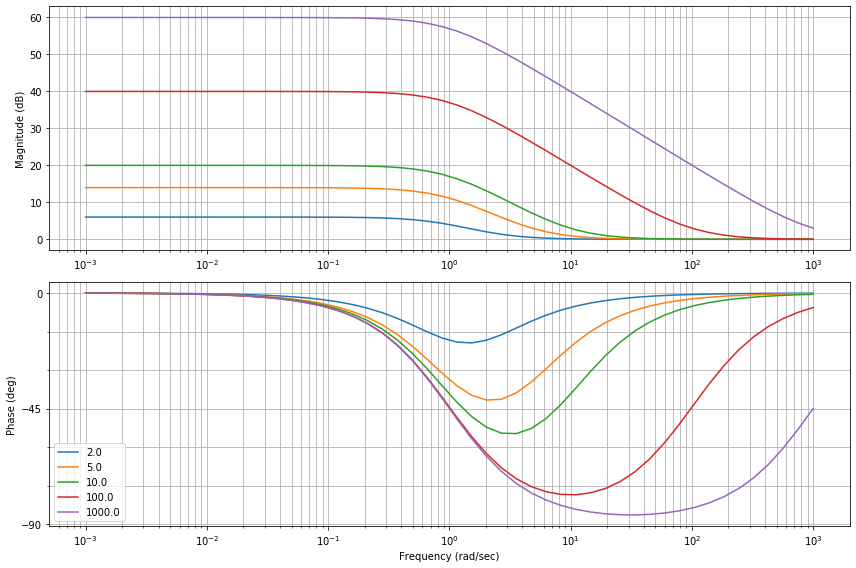

In [0]:
w_r = 1
M = np.array([2.,5.,10.,100.,1000.])
z = w_r*M 
p = w_r

for i in range(0,M.size):
    Clag = tf([M[i]/z[i], M[i]],[1./p, 1.]) 
    mag, phase, w = bode(Clag, omega_limits=omega, Hz=False, label=str(M[i]))
                        
plt.legend()
plt.tight_layout()

### 18.1.5 Phase Lead Filter ($|p| > |z|$)
$C_{Lead} (s) = M \frac{s + \frac{\omega_{Lead}}{\sqrt{M}}}{s + \omega_{Lead} \sqrt{M} }$,  where $M$ is the amount of separation (in frequency) between the pole $p$ and zero $z$  $M = \frac{z}{p}$ ( and $p = \frac{z}{M}$ ), and $\omega_{Lead}$ is the frequency you want the phase bump to occur at (usually $\omega_{Lead} = \omega_{co}$).

The **main purpose of a phase lead filter is to raise the phase margin at $\omega_{co}$**.  The side-effect is that the magnitude is raised for $\omega > \omega_{Lead}$, so it usually must be paired with a low pass filter so that noise is not amplified by it.  The amount of phase gain is $\phi_{Lead} = \tan^{-1}\sqrt{M} - \tan^{-1} \sqrt{1/M}$.  Given a desired $\phi_{Lead}$, we can compute the $M$ needed with: 

$M = \frac{1 + \sin(\phi_{Lead})}{1 - \sin(\phi_{Lead})}$

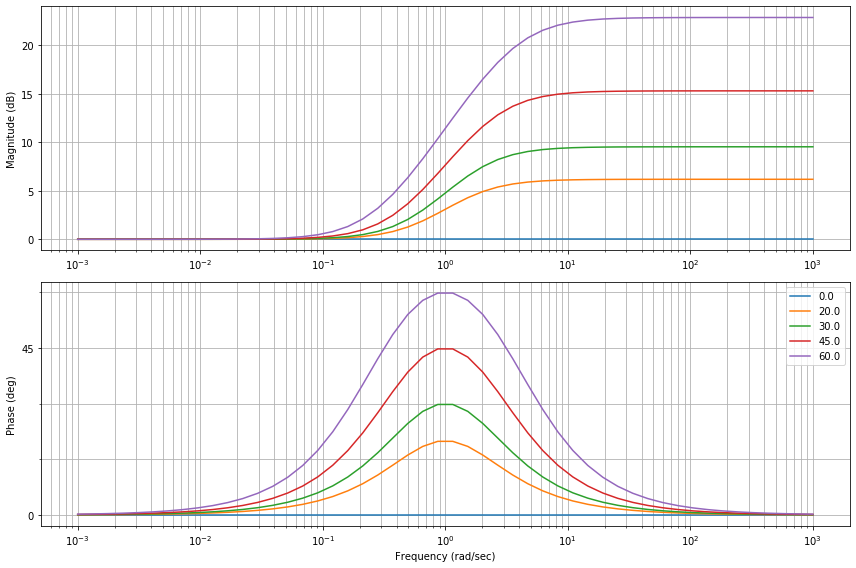

In [0]:
w_lead = 1.
phi_lead = np.array([0., 20. ,30., 45., 60.]) # Desired lead in degrees
phi = np.pi/180.*phi_lead
M = (1. + np.sin(phi))/(1. - np.sin(phi)) # compute the separation needed

for i in range(0,M.size):
    Clead = tf([M[i], M[i]*w_lead/np.sqrt(M[i])],[1., w_lead*np.sqrt(M[i])]) 
    mag, phase, w = bode(Clead, omega_limits=omega, Hz=False, label=str(phi_lead[i]))
                
plt.legend()
plt.tight_layout()

The amount of phase gain that can be brought by a single lead controller is limited. The following plots the approximate phase gain that is possible, by separation $M$. 

Text(0, 0.5, 'Phase Gain (deg)')

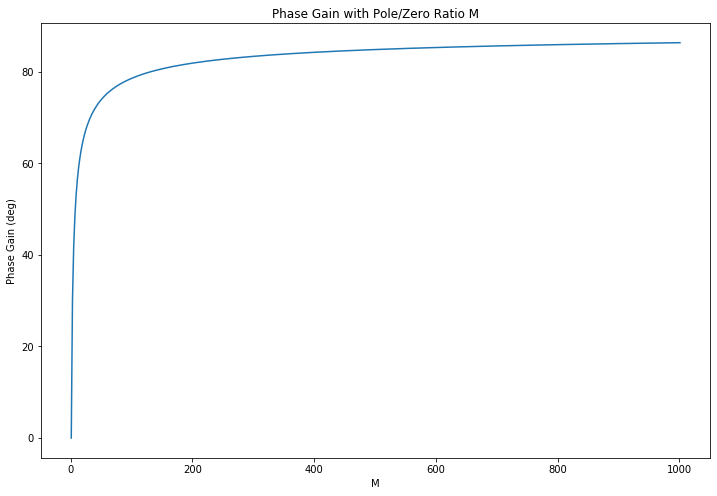

In [0]:
# Phase Gain with Pole/Zero Ratio M: 
M = np.linspace(1.,1001.,500.)#1:2:1000 

phi_l = np.arctan(np.sqrt(M)) - np.arctan(np.sqrt(1./M))
plt.plot(M,phi_l*180./np.pi)
plt.title('Phase Gain with Pole/Zero Ratio M')
plt.xlabel('M')
plt.ylabel('Phase Gain (deg)')

### 18.1.6 Simple Example
Open loop plant of: $P(s) = \frac{1}{s + 1}$, 

design a controller C(s) so that the closed loop system satisfies the following
constraints:
> (1) Tracks a ramp within $\gamma_1 = 0.03$.

> (2) Attenuate noise with frequency content above $\omega_{no} = 10$ rad/sec by $\gamma_n = 0.1$.

> (3) Reject input disturbances with frequencies content below $\omega_{d_{in}} = 0.1$ rad/sec
by $\gamma_{d_{in}} = 0.1$.

> (4) Phase margin that is approximately 60 degrees.

The design specifications are on the Bode plot shown below.

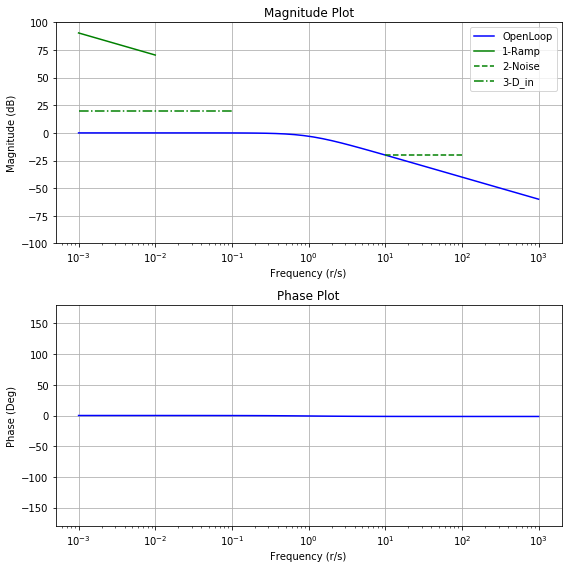

In [0]:
P = tf([1.],[1., 1.])
magP,phP,wP = bode(P,omega_limits=omega,Hz=False,Plot=False)
# Constraint 1: Track Ramp 
gamma_1 = 0.03
omega_1 = np.linspace(0.001,0.01,100)
mag_1 = 20.*np.log10(1./gamma_1)*np.ones_like(omega_1) - 20.*np.log10(omega_1)

# Constraint 2: Attenuate noise
gamma_n = 0.1
omega_n = np.linspace(10.,100,100)
mag_n = 20.*np.log10(gamma_n)*np.ones_like(omega_n)

# Constraint 3: Reject input disturbances: 
gamma_din = 0.1
omega_din = np.linspace(0.001,0.1,1000)
mag_din = 20.*np.log10(1./gamma_din)*np.ones_like(omega_din)

#TODO: Create a function to support a bode plot with design requirments!!
# Plot open loop Bode with constraintsb
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
axs = axs.ravel()
axs[0].plot(wP,20.*np.log10(magP),'b',label='OpenLoop')
axs[0].plot(omega_1,mag_1,'g',label='1-Ramp')
axs[0].plot(omega_n,mag_n,'g--',label='2-Noise')
axs[0].plot(omega_din,mag_din,'g-.',label='3-D_in')
axs[0].set_xscale('log')
axs[0].grid(True)
axs[0].set_ylim(-100.,100.)
axs[0].set_title('Magnitude Plot')
axs[0].set_xlabel('Frequency (r/s)')
axs[0].set_ylabel('Magnitude (dB)')

axs[1].plot(wP,phP,'b',label='OpenLoop')
axs[1].set_xscale('log')
axs[1].grid(True)
axs[1].set_ylim(-180.,180.)
axs[1].set_title('Phase Plot')
axs[1].set_xlabel('Frequency (r/s)')
axs[1].set_ylabel('Phase (Deg)')
axs[0].legend()

fig.tight_layout()

We need to design the system so that the blue curve is above constraint 1 (track ramp) and above constraint 3 (reject input dist.) and below constraint 2 (noise).  To do that, first objective will be to increase the system type:  

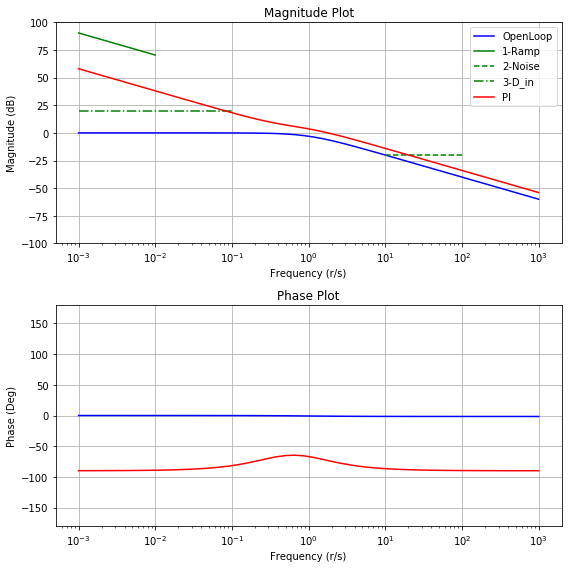

In [0]:
# Add integral control - retrieve control from section 18.1.2 above
ki = 0.4 # try something different and see what happens. 
kp = 2.  # try something different and see what happens. 
Cpi = kp*tf([1., ki],[1., 0.])
magI,phI,wI = bode(P*Cpi,omega_limits=omega,Hz=False,Plot=False)
axs[0].plot(wI, 20.*np.log10(magI),'r',label='PI')
axs[0].legend()
axs[1].plot(wI,phI*180./np.pi,'r',label='PI')
fig # makes it plot the figure again

So, now we are parrallel to the first constraint and above the second.  We need to be above the first - try a lag controller: 

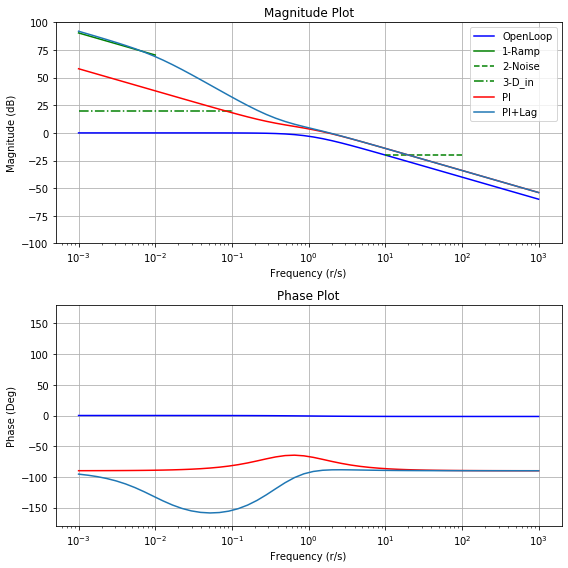

In [0]:
# Lag Controller, to boost our magnitude above the constraint as omega -> 0
# Use the Lag controller as specified above in 18.1.4
w_r = 0.01
M = 50.
z = w_r*M 
p = w_r

Clag = tf([M/z, M],[1./p, 1.])
magIL,phIL,wIL = bode(P*Cpi*Clag,omega_limits=omega,Hz=False,Plot=False)
axs[0].plot(wIL, 20.*np.log10(magIL),label='PI+Lag')
axs[0].legend()
axs[1].plot(wIL,phIL*180./np.pi,label='PI+Lag')
fig # makes it plot the figure again


Now we need to address the noise spec - Number 2.  We need to add a LPF, from 18.1.3

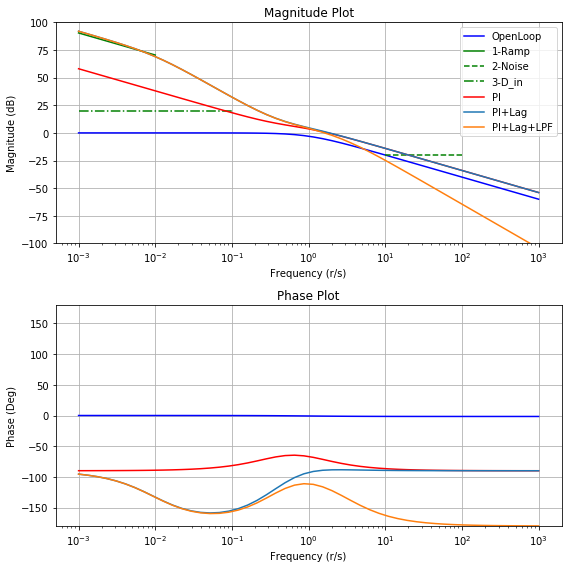

In [0]:
# Add Low pass filter to get below our 2nd specification
p = 3
Clpf = tf([p],[1., p])
magILF,phILF,wILF = bode(P*Cpi*Clag*Clpf,omega_limits=omega,Hz=False,Plot=False)
axs[0].plot(wILF, 20.*np.log10(magILF),label='PI+Lag+LPF')
axs[0].legend()
axs[1].plot(wILF,phILF*180./np.pi,label='PI+Lag+LPF')
fig # makes it plot the figure again

Now that everything looks correct, let's check the margins on the design to make sure we are above/near $60^o$ of phase margin. Then, plot the final Bode Plot comparing the open loop system to our control design (loopgain).  

Phase Margin:  62.71549416867583  Gain Margin:  inf
Controller Transfer Function:  
 600 s^2 + 540 s + 120
-----------------------
100 s^3 + 301 s^2 + 3 s



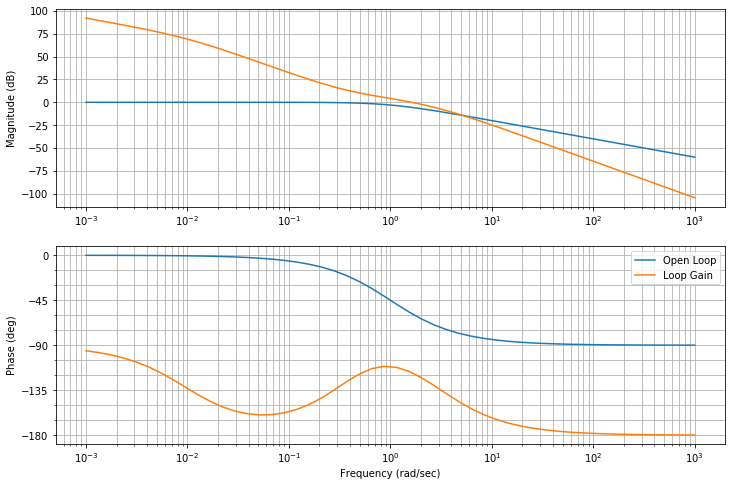

In [0]:
C = Cpi*Clag*Clpf
PC = P*C

gm, pm, Wcg, Wcp = margin(PC)
print('Phase Margin: ', pm, ' Gain Margin: ', gm)

magF, phF, wF = bode(P, PC, omega_limits=omega, Hz=False)
plt.legend(['Open Loop','Loop Gain'])

print('Controller Transfer Function: ', C)
Css = tf2ss(C)
#A,B,C,D = ssData(Css)

### 18.1.7 Controller Implementation 

The loopshaping design procedure produces a controller $C(s)$ that will have multiple elements including integrators, lead and lag filters, and low pass filters.  Each of these elements are straightforward to implement using analog circuits.  However, if the controller is to be implemented on digital hardware using computer code, what is the best way to proceed? 

While there are many possibilities, one option that is straightforward to implement and that fits well with the previous chapters, is to **implement the controller using state space equations**. The controller

$U(s) = C(s) E(s)$

is first converted to continuous time state space equations using, for example, control canonical form, to produce the equations

$\dot{z}_C = A_{C}z_C + B_{C}e $

$u = C_{C}z_C + D_{C}e $

where $e(t)=r(t)-y(t)$ is the input to the state space equations, and the control signal $u(t)$ is the output.  

In the example of the previous section we get

$C(s) = \frac{10 s^2 + 12 s + 3.2}{s^3 + 5.016 s^2 + 0.08 s}.$

Therefore, using control canonic form, the controller implementation is 

$\dot{z}_C = \begin{pmatrix} -5.016 & 0.08 & 0 \\ 1 & 0 & 0 \\ 0 & 1 & 0\end{pmatrix} z_C +\begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}e $

$u = \begin{pmatrix} 10 & 12 & 3.2 \end{pmatrix}z_C.$


In Matlab, the commands to find the state space equations are given by
```
[num,den] = tfdata(C,'v');
[A_C,B_C,C_C,D_C]=tf2ss(num,den)
```

The controller is then implemented by integrating the differential equations between sample times.  If $T_s$ is the sample time, and $N=10$ Euler steps are used between each sample, then Matlab code that implements the controller is given by
```
function u=ctrl(in,P)
    r      = in(1); % reference input
    y      = in(2); % plant output
    t      = in(3); % current time 
    % define and initialize persistent variables
    persistent z_C  % state of the controller
    if t==0,
        z_C = zeros(size(P.A_C,1),1);
    end
    % error signal
    error = r - y;   
    % Euler integration steps per sample
    N = 10; 
    % solve differential equation for controller
    for i=1:N, 
        z_C = z_C + P.Ts/N*( P.A_C*z_C ...
                             + P.B_C*error );
    end
    % output equation for the controller
    u = P.C_C*z_C + P.D_C*error;   
end
```

In python, there are a couple possibilities.  You might use the fuction ```ssdata```, but I do not think that it has been implemented fully yet.  The easiest way would be to print the Control trasfer function and manually implement it into Control Canonical Form

### 18.1.8 Pre-filter
At times it can be challenging to keep the phase margin around 60 degrees when trying to meet the design constraints.  When this happens, often the phase margin is reduced, which causes rining in the closed loop step response.  The Pre-Filter attempts to **attentuate frequencies in the desired input $r(t)$ that are near the natural frequency of the closed loop system.** 


$F(s) = \frac{p}{s + p}$, so it is simply a low pass filter.  See 18.1.3 above for examples of the Bode Plot. 

The goal then is to set $p$ near/at the natural frequency of the closed loop system $\frac{P(s)C(s)}{1 + P(s)C(s)}$. The closed loop will likely not be second order, so the easiest way to determine $\omega_n$ is by plotting the Bode plot of the closed loop system and reading off the location of the magnitude bump.


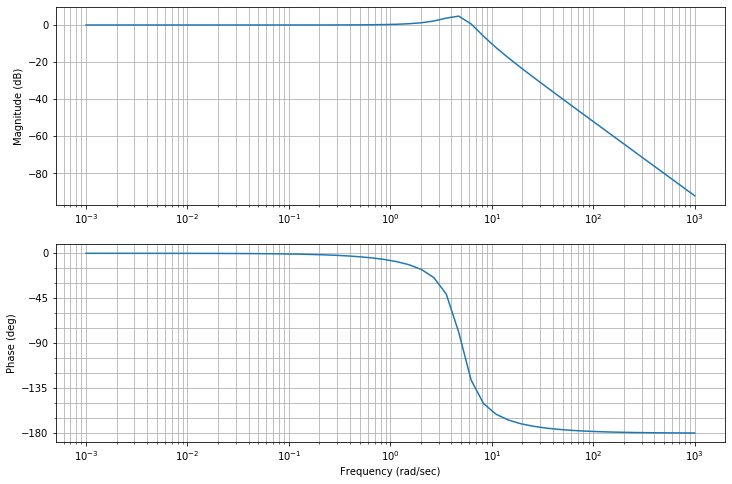

In [0]:
# Set up example system with low damping: 
CL = tf([25.],[1., 3., 25.]); #say this is our closed loop tf: PC/(1 + PC)

mag,ph,w = bode(CL,omega_limits=omega,Hz=False,label='ClosedLoop') 

Text(0, 0.5, 'Amplitude')

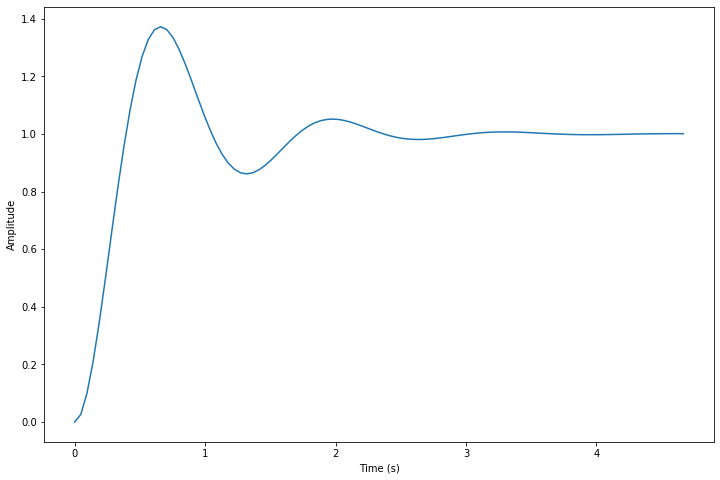

In [0]:
#Resulting step response: 
yout, t = step(CL)
plt.plot(t,yout,label='ClosedLoop')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Notice the amplitude bump in the Bode plot at $\omega = 5$ r/s.  If we add a prefilter here to attenuate frequencies larger than 3 r/s (want to back it off just a little), our response improves slightly.  Note that we take a hit in rise time (no such thing as a free lunch). 

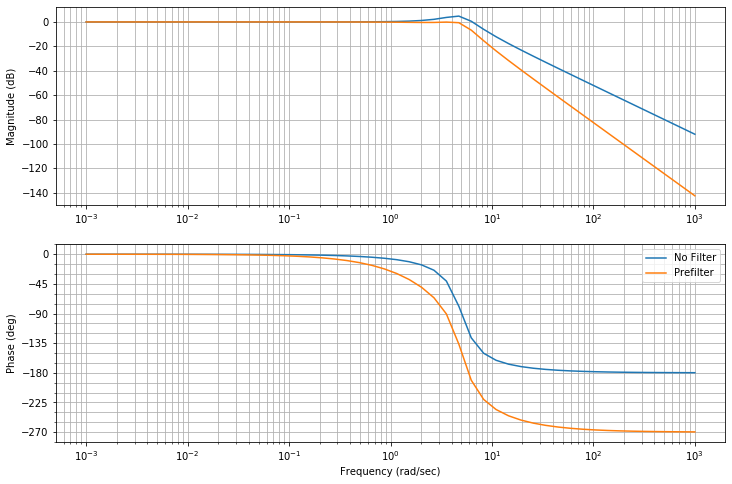

In [0]:
p = 3. 
F = tf([p],[1., p]) 
CL2 = F*CL 
#Now:
mag,ph,w = bode(CL,CL2,omega_limits=omega,Hz=False) 
plt.legend(['No Filter','Prefilter'], loc=0)

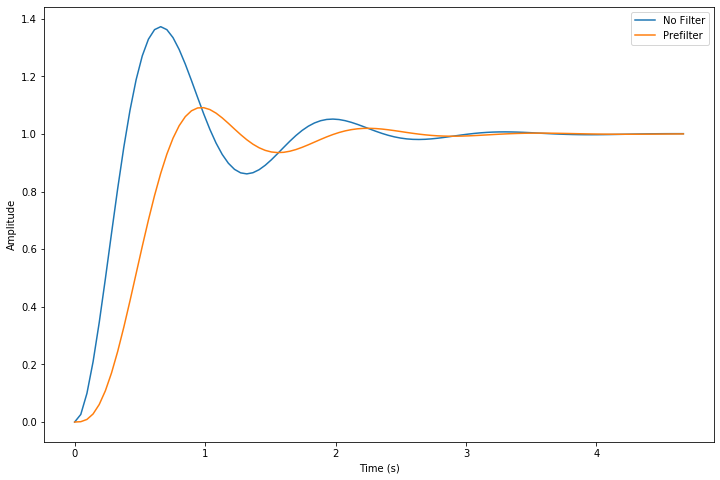

In [0]:
#Resulting step response: 
yout2, t2 = step(CL2)
plt.plot(t, yout, label='No Filter')
plt.plot(t2, yout2, label='Prefilter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

### 18.1.9 Successive Loop Closure Design
When loopshaping is used to design an inner and outer loop controller in a successive loop closure design, the design of the outer loop can take into account the complete dynamics of the inner loop.  This is in contrast to the design of PID controllers in Chapter 10 where the inner loop was replaced with the DC-gain.  The figure below shows the system architecture for loopshaping design.  The inner and outer loop controllers are accompanied by the prefilter $F(s)$ which is only on the outer loop.

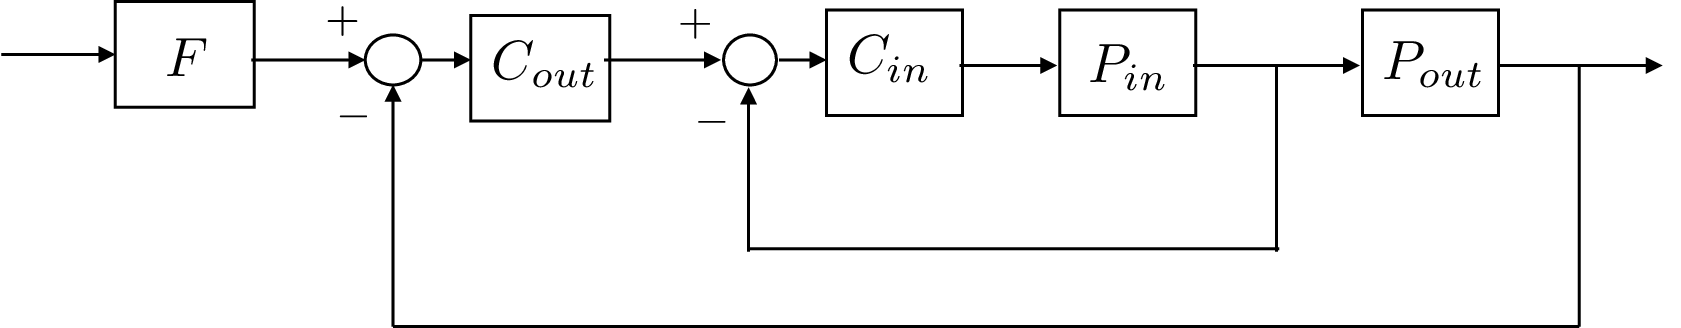

In [0]:
Img1

The first step is to design the inner loop controller $C_{in}(s)$ using the plant $P_in(s)$.  **However, for the design of the outer loop controller $C_{out}(s)$, we can use the outer loop plant in cascade with the inner closed-loop system.**  Therefore, the plant for the outer loop design is given by

$P = P_{out}\left(\frac{P_{in}C_{in}}{1+P_{in}C_{in}}\right).$

# 18.2 Design Study A: Single Link Robot Arm
For this homework assignment we will use loopshaping to improve the PID controllers developed in HW10.  Let $C_{pid}(s)$ be the PID controller designed in HW10.  The final control will be $C(s) = C_{pid}(s)C_{l}(s)$ where $C_l$ is designed using loopshaping techniques.

> (a)  Design $C_l(s)$ to meet the following objectives:
> >	(1) Improve tracking and disturbance rejection by a factor of 10 for reference signals and disturbances below $0.07$ rad/sec, 

> > (2) Improve noise attention by a factor of 10 for frequencies above $1000$ radians/sec.

> > (3) Phase margin that is approximately $PM=60$ degrees.
	
> (b) Add zero mean Gaussian noise with standard deviation $\sigma^2=0.01$ to the Simulink diagram developed in HW10.

> (c) Implement the controller $C(s)$ in Simulink using its state space equivalent.

> (d) Note that despite having a good phase margin, there is still significant overshoot, due in part to the windup effect in the phase lag filter.  This can be mitigated by adding a prefilter, that essentially modifies the hard step input into the system.  Add a low pass filter for $F(s)$ as a prefilter to flatten out the closed loop Bode response and implement in Simulink using its discrete-time state space equivalent.

In [0]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_a_arm/python/')
sys.path.append('control_book_public_solutions/_a_arm/python/hw10/')  # add homework directory
import armParam as P
import hw10.armParamHW10 as P10
omega = (0.001,10000)

kp:  0.45374999999999993
ki:  0.1
kd:  0.06665499999999998


In [0]:
# Compute the transfer functions: 
#G2 = tf([3/P.m/P.ell**2],[1, 3*P.b/P.m/P.ell**2, -3.*P.g*np.sin(th_e)/2./P.ell]) # Jacobian Linearized
G = tf([2./P.m/P.ell**2.],[1., 2.*P.b/P.m/P.ell**2., 0.]) # feedback linearlized form 
print("Plant: ", G)
C_pid = tf([P10.kd,P10.kp,P10.ki],[P.sigma,1.,0.]) 
print("Control: ", C_pid)
PC = series(G,C_pid)
print("Loopgain from PID: ", PC)

Plant:  
    44.44
-------------
s^2 + 2.222 s

Control:  
0.06665 s^2 + 0.4537 s + 0.1
----------------------------
        0.05 s^2 + s

Loopgain from PID:  
  2.962 s^2 + 20.17 s + 4.444
--------------------------------
0.05 s^4 + 1.111 s^3 + 2.222 s^2



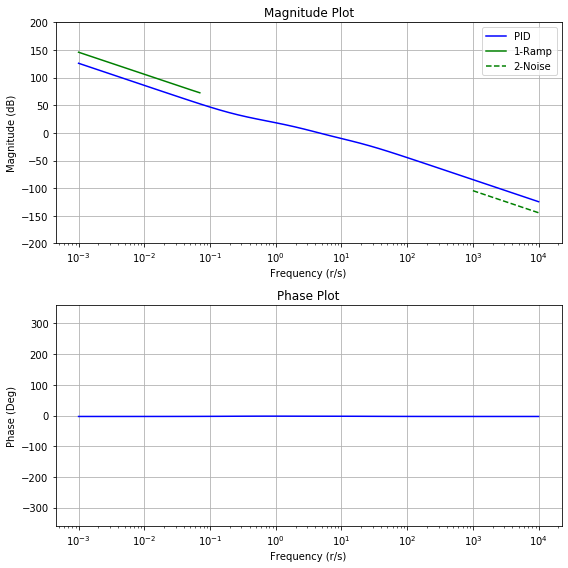

In [0]:
magP,phP,wP = bode(PC,omega_limits=omega,Hz=False,Plot=False)

# Constraint 1: Track order of magnitude better and improve disturbance rejection 
# Find out where we are now: 
omega_1 = np.linspace(0.001,0.07,300)
magP1,phP1,wP1 = bode(PC,omega_1,Hz=False,Plot=False)
magP1new = 10.*magP1 # 10 times better for tracking

mag_1 = 20.*np.log10(magP1new)#*np.ones_like(omega_1) - 20.*np.log10(omega_1)

# Constraint 2: Attenuate noise
omega_n = np.linspace(1000.,10000,100)
magP2,phP2,wP2 = bode(PC,omega_n,Hz=False,Plot=False )
mag2new = magP2/10. # 10 times better for noise suppression
mag_n = 20.*np.log10(mag2new)#*np.ones_like(omega_n)

#TODO: Create a function to support a bode plot with design requirments!!
# Plot open loop Bode with constraintsb
fig1, axs1 = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
axs1 = axs1.ravel()
axs1[0].plot(wP,20.*np.log10(magP),'b',label='PID')
axs1[0].plot(omega_1,mag_1,'g',label='1-Ramp')
axs1[0].plot(omega_n,mag_n,'g--',label='2-Noise')
#axs[0].plot(omega_din,mag_din,'g-.',label='3-D_in')
axs1[0].set_xscale('log')
axs1[0].grid(True)
axs1[0].set_ylim(-200.,200.)
axs1[0].set_title('Magnitude Plot')
axs1[0].set_xlabel('Frequency (r/s)')
axs1[0].set_ylabel('Magnitude (dB)')

axs1[1].plot(wP,phP,'b',label='PID')
axs1[1].set_xscale('log')
axs1[1].grid(True)
axs1[1].set_ylim(-360.,360.)
axs1[1].set_title('Phase Plot')
axs1[1].set_xlabel('Frequency (r/s)')
axs1[1].set_ylabel('Phase (Deg)')
axs1[0].legend()

fig1.tight_layout()

The first step is to add a Lag controller, to boost the control above the first specification, the tracking spec. 

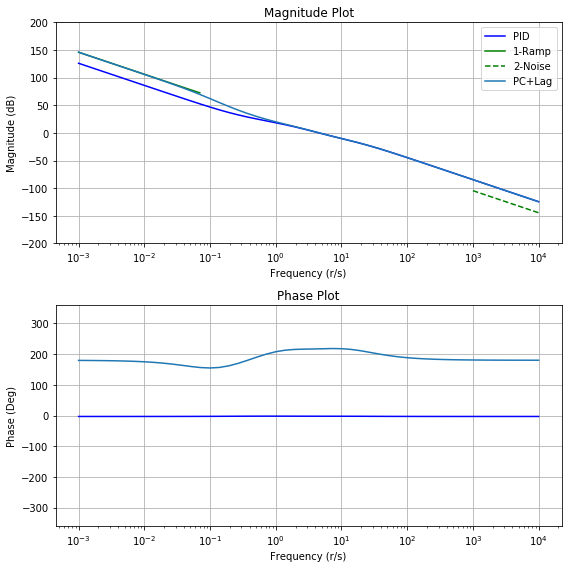

In [0]:
w_r = 0.07
M = 10.
z = w_r*M 
p = w_r

Clag = tf([M/z, M],[1./p, 1.])
magL,phL,wL = bode(PC*Clag,omega_limits=omega,Hz=False,Plot=False)
axs1[0].plot(wL, 20.*np.log10(magL),label='PC+Lag')
axs1[0].legend()
axs1[1].plot(wL,phL*180./np.pi,label='PC+Lag')
fig1 # makes it plot the figure again

Looking at the phase margin, it does not look great.  Add a Lead Controller to build up the phase margin. We want the bandwidth of this loop to be about 40 r/s, so add it near there. 

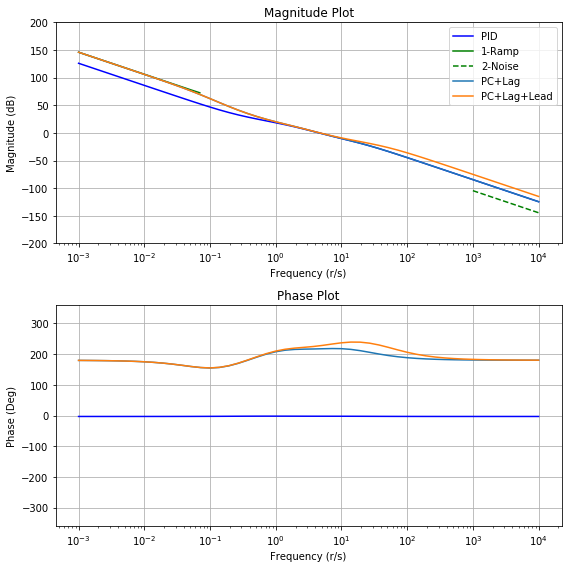

In [0]:
w_lead = 30.
phi_lead = 30. # Desired lead in degrees
phi = np.pi/180.*phi_lead
M = (1. + np.sin(phi))/(1. - np.sin(phi)) # compute the separation needed

Clead = tf([M, M*w_lead/np.sqrt(M)],[1., w_lead*np.sqrt(M)]) 
magLL, phLL, wLL = bode(PC*Clag*Clead, omega_limits=omega, Hz=False, Plot=False) 
axs1[0].plot(wLL, 20.*np.log10(magLL),label='PC+Lag+Lead')
axs1[0].legend()
axs1[1].plot(wLL,phLL*180./np.pi,label='PC+Lag+Lead')
fig1 # makes it plot the figure again

Now, the final step will be to add a low pass filter, so that we can meet our second step.  Add the filter at p = 50, to make sure we get it applying at the right frequency.  

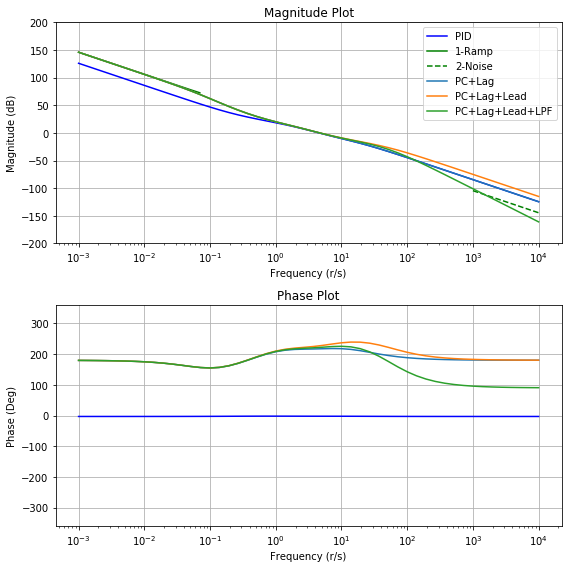

In [0]:
# Add Low pass filter to get below our 2nd specification
p = 50
Clpf = tf([p],[1., p])
magLLF,phLLF,wLLF = bode(PC*Clead*Clag*Clpf,omega_limits=omega,Hz=False,Plot=False)
axs1[0].plot(wLLF, 20.*np.log10(magLLF),label='PC+Lag+Lead+LPF')
axs1[0].legend()
axs1[1].plot(wLLF,phLLF*180./np.pi,label='PC+Lag+Lead+LPF')
fig1 # makes it plot the figure again

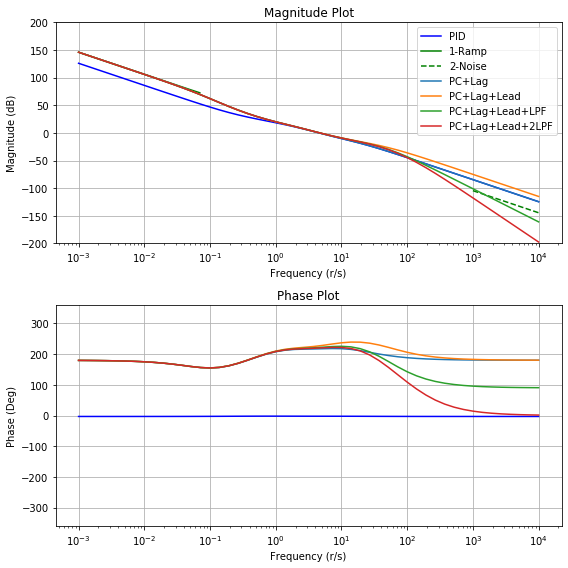

In [0]:
p = 150
Clpf2 = tf([p],[1., p])
magLLFF,phLLFF,wLLFF = bode(PC*Clead*Clag*Clpf*Clpf2,omega_limits=omega,Hz=False,Plot=False)
axs1[0].plot(wLLFF, 20.*np.log10(magLLFF),label='PC+Lag+Lead+2LPF')
axs1[0].legend()
axs1[1].plot(wLLFF,phLLFF*180./np.pi,label='PC+Lag+Lead+2LPF')
fig1 # makes it plot the figure again

In [0]:
# TODO???: Adjust the proportional gain to make the crossover happen in the
#          same spot it did for PID. 

# TODO??? Add a prefilter to eliminate the overshoot? 

Phase Margin:  40.04889746538359  Gain Margin:  17.044402662987846


/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/matfuncs.py:705: LinAlgWarning: Ill-conditioned matrix (rcond=2.32174e-24): result may not be accurate.
  return solve(Q, P)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/matfuncs.py:705: LinAlgWarning: Ill-conditioned matrix (rcond=2.66542e-23): result may not be accurate.
  return solve(Q, P)


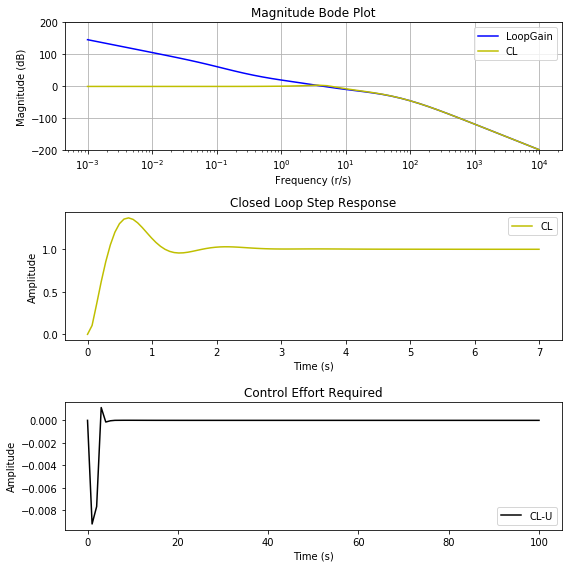

In [0]:
# Get the final specs for the PM and GM: 
C = C_pid*Clead*Clag*Clpf*Clpf2
PC2 = G*C

gm, pm, Wcg, Wcp = margin(PC2)
print('Phase Margin: ', pm, ' Gain Margin: ', gm)

# Open-loop transfer function
OPEN = G*C;
# closed loop transfer function from R to Y
CLOSED_R_to_Y = (G*C/(1+G*C))
# closed loop transfer function from R to U
CLOSED_R_to_U = (C/(1+C*G))

magO,phO,wO = bode(OPEN,omega_limits=omega,Hz=False,Plot=False)
magCL,phCL,wCL = bode(CLOSED_R_to_Y,omega_limits=omega,Hz=False,Plot=False)

youtCL, tCL = step(CLOSED_R_to_Y)
youtU, tU = step(CLOSED_R_to_U)

figA, axsA = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))
axsA = axsA.ravel()
# Bode Magnitude plot
axsA[0].plot(wO, 20.*np.log10(magO),'b',label='LoopGain')
axsA[0].plot(wCL, 20.*np.log10(magCL),'y',label='CL')
axsA[0].set_xscale('log')
axsA[0].grid(True)
axsA[0].set_ylim(-200.,200.)
axsA[0].set_title('Magnitude Bode Plot')
axsA[0].set_xlabel('Frequency (r/s)')
axsA[0].set_ylabel('Magnitude (dB)')
axsA[0].legend()
# Step plot
axsA[1].plot(tCL, youtCL, 'y', label='CL')
axsA[1].set_xlabel('Time (s)')
axsA[1].set_ylabel('Amplitude')
axsA[1].set_title('Closed Loop Step Response')
axsA[1].legend()
# Effort Step plot
axsA[2].plot(tU, youtU, 'k', label='CL-U')
axsA[2].set_xlabel('Time (s)')
axsA[2].set_ylabel('Amplitude')
axsA[2].set_title('Control Effort Required')
axsA[2].legend()

figA.tight_layout()